# Improved baseline using Darts

Here we use the Darts library to quickly generate a more sophisticated baseline model: yearly seasonality + linear trend

In [15]:
from darts import TimeSeries

train = TimeSeries.from_csv("data/train.csv", time_col="DATETIME", value_cols="SOLAR PV", fill_missing_dates=True)
test = TimeSeries.from_csv("data/test.csv", time_col="DATETIME", value_cols="SOLAR PV", fill_missing_dates=True)

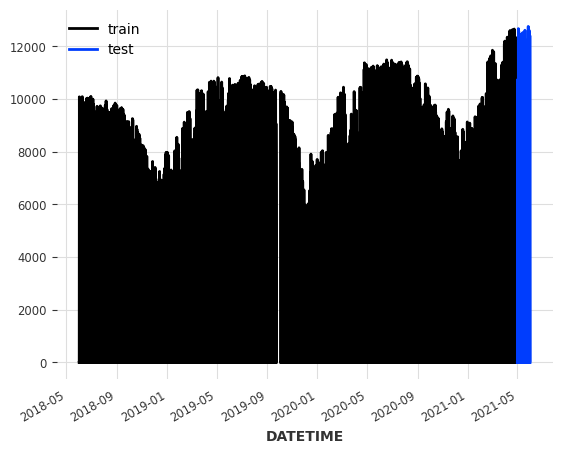

In [16]:
train.plot(label="train")
test.plot(label="test")

Ok, let's plot the ACF and see if we can see the seasonalities.  We expect there to be a typical curve daily, but also yearly.  And the day curve varies yearly.  So I expect there to be strong lags spikes at 24, and 24*365ish.

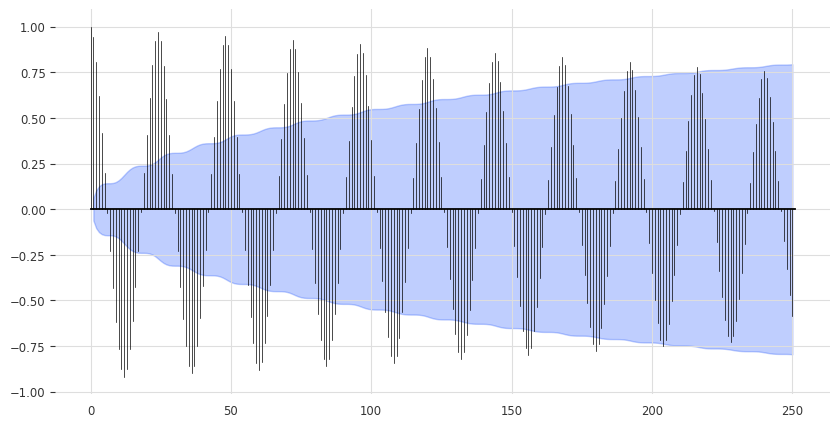

In [6]:
from darts.utils.statistics import plot_acf
plot_acf(train[:1000], alpha=0.05, max_lag=250)

# first we see the daily patterns here.
# seems like significance stretches back about 10 days.

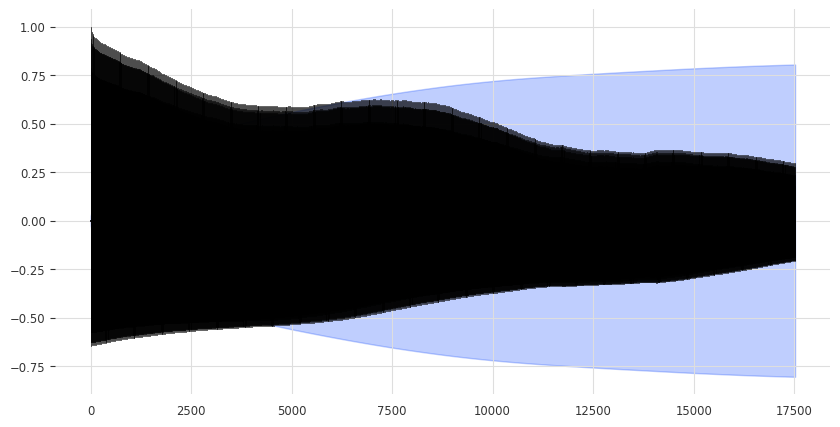

In [7]:
from darts.dataprocessing.transformers import MissingValuesFiller
train = MissingValuesFiller().transform(train)

plot_acf(train, alpha=0.05, max_lag=24*365*2)

# also, we can extend the ACF out 2 years, and see that there's a yearly component as well.

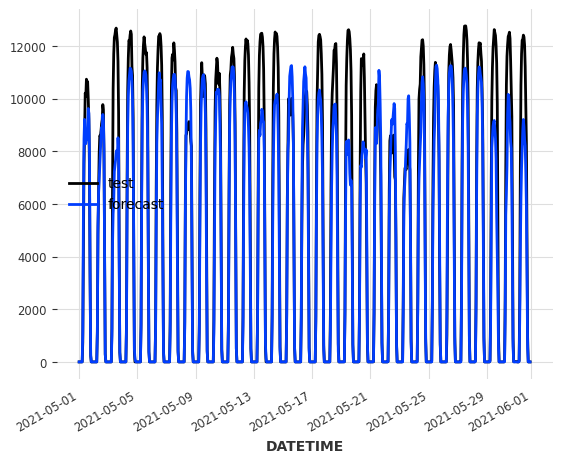

In [17]:
from darts.models import NaiveSeasonal
yearly_model = NaiveSeasonal(K=24*365)

yearly_model.fit(train)
seasonal_forecast = yearly_model.predict(len(test))

test.plot(label="test")
seasonal_forecast.plot(label="forecast")

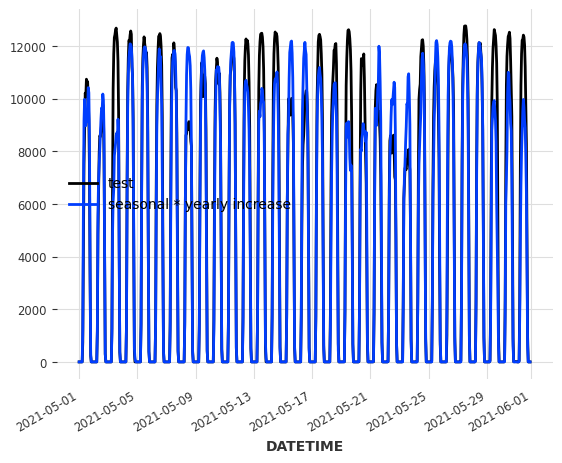

In [46]:
# now we should roughly calculate our fractional increase from a year before
import numpy as np

year1 = train[:24*365].values().mean()
year2 = np.nanmean(train[24*365:2*24*365].values())
yearly_increase = 1 + (year2 - year1) / year2

# and multiply our seasonal forecast to adjust appropriately
combined_forecast = seasonal_forecast * yearly_increase

test.plot(label="test")
combined_forecast.plot(label="seasonal * yearly increase")

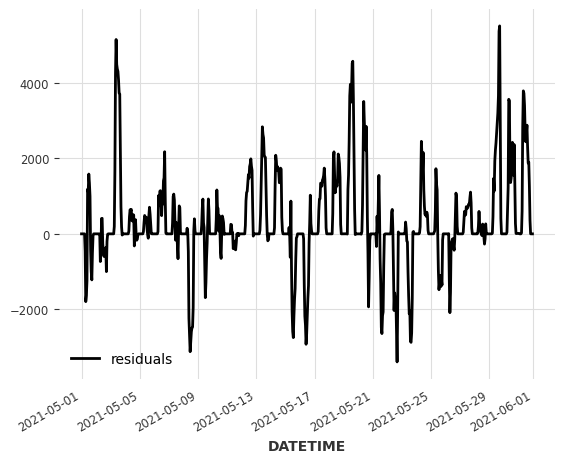

In [47]:
# and here's our residuals!
(test - combined_forecast).plot(label="residuals")

In [53]:
# and our MAE...
from darts.metrics.metrics import mae

print("MAE:", round(mae(test, combined_forecast), 2), "MW")

MAE: 686.2 MW


Well, our best MAE from the first baselines was 686.7 MW.  So we didn't really improve anything, although our residuals seem a bit more centered.  Time to apply some actual models, I think!  680 MW is a decent baseline MAE, though.